In [1]:
import os

# Define all folders
folders = [
    "citrus_severity_project",
    "citrus_severity_project/data/raw_images",
    "citrus_severity_project/src",
    "citrus_severity_project/outputs/masks/leaf",
    "citrus_severity_project/outputs/masks/disease",
    "citrus_severity_project/outputs/overlays",
    "citrus_severity_project/models",
    "citrus_severity_project/results",
    "citrus_severity_project/notebooks"
]

# Create folders if not exist
for f in folders:
    os.makedirs(f, exist_ok=True)

print("✅ Project skeleton created successfully!")


✅ Project skeleton created successfully!


In [4]:
import os
import glob
import pandas as pd

# Root path to images
data_path = "C:\\Users\\Sai charan\\Downloads\\citrus_severity_project\\citrus_severity_project\\data\\raw_images"

# Check classes
classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
print("Detected classes:", classes)

# Count images per class
counts = {}
for cls in classes:
    img_paths = glob.glob(f"{data_path}/{cls}/*.*")
    counts[cls] = len(img_paths)

df_counts = pd.DataFrame(list(counts.items()), columns=["Class", "Image_Count"])
display(df_counts)


Detected classes: ['Blackspot', 'Canker', 'Greening', 'Healthy', 'Melanose']


,Class,Image_Count
0,Blackspot,171
1,Canker,163
2,Greening,204
3,Healthy,58
4,Melanose,13


In [6]:
import os
import cv2
import pandas as pd

# Path to your raw images
data_path ="C:\\Users\\Maahi\\Downloads\\citrus_severity_project\\citrus_severity_project\\data\\raw_images"

# Make sure the folder exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"❌ Folder not found: {data_path}")

# Collect all image info
rows = []
for root, _, files in os.walk(data_path):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(root, f)
            img = cv2.imread(path)
            if img is None:
                continue
            h, w, _ = img.shape
            cls = os.path.basename(root)
            rows.append({
                "filename": f,
                "class": cls,
                "path": path,
                "width": w,
                "height": h
            })

# Create DataFrame
df_info = pd.DataFrame(rows)


# Display first few rows
display(df_info.head())


,filename,class,path,width,height
0,74.jpg,Blackspot,C:\Users\Sai charan\Downloads\citrus_severity_...,1520,1417
1,78.jpg,Blackspot,C:\Users\Sai charan\Downloads\citrus_severity_...,1520,1417
2,b (11).png,Blackspot,C:\Users\Sai charan\Downloads\citrus_severity_...,256,256
3,b (126).png,Blackspot,C:\Users\Sai charan\Downloads\citrus_severity_...,256,256
4,b (131).png,Blackspot,C:\Users\Sai charan\Downloads\citrus_severity_...,256,256


Processing Blackspot:   0%|          | 0/171 [00:00<?, ?it/s]

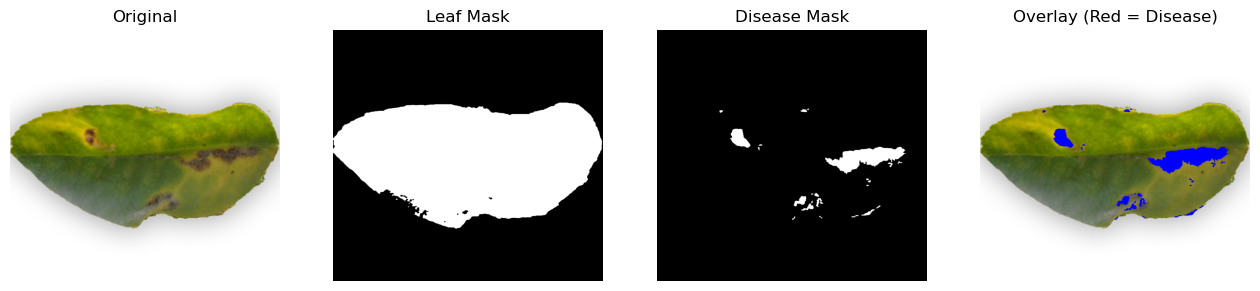

Processing Melanose: 100%|██████████| 13/13 [00:00<00:00, 26.36it/s]

✅ All leaf and disease masks generated successfully!


In [7]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===============================
# Paths
# ===============================
input_path = "C:\\Users\\Maahi\\Downloads\\citrus_severity_project\\citrus_severity_project\\data\\raw_images"
leaf_output = "C:\\Users\\Maahi\\Downloads\\citrus_severity_project\\citrus_severity_project\\outputs\\masks\\leaf"
disease_output = "C:\\Users\\Maahi\\Downloads\\citrus_severity_project\\citrus_severity_project\\outputs\\masks\\disease"

os.makedirs(leaf_output, exist_ok=True)
os.makedirs(disease_output, exist_ok=True)

# ===============================
# Leaf Mask (full leaf including diseased areas)
# ===============================
def get_leaf_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Green (healthy leaf)
    lower_green = np.array([30, 30, 30])
    upper_green = np.array([90, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Yellow/Brown/Light disease color (to include full leaf)
    lower_disease_like = np.array([10, 40, 40])
    upper_disease_like = np.array([35, 255, 255])
    mask_disease_like = cv2.inRange(hsv, lower_disease_like, upper_disease_like)

    leaf_mask = cv2.bitwise_or(mask_green, mask_disease_like)

    # Morphological cleaning for smooth boundaries
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)
    leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_OPEN, kernel)
    leaf_mask = cv2.medianBlur(leaf_mask, 5)

    return leaf_mask

# ===============================
# Disease Mask (only diseased spots inside leaf)
# ===============================
def get_disease_mask(img, leaf_mask):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Brown disease spots
    lower_brown = np.array([8, 50, 50])
    upper_brown = np.array([25, 255, 200])
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)

    # Dark/black necrosis spots
    lower_dark = np.array([0, 0, 0])
    upper_dark = np.array([180, 255, 60])
    mask_dark = cv2.inRange(hsv, lower_dark, upper_dark)

    disease_mask = cv2.bitwise_or(mask_brown, mask_dark)

    # Restrict strictly to leaf area
    disease_mask = cv2.bitwise_and(disease_mask, leaf_mask)

    # Morphological cleaning
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    disease_mask = cv2.morphologyEx(disease_mask, cv2.MORPH_OPEN, kernel)
    disease_mask = cv2.morphologyEx(disease_mask, cv2.MORPH_CLOSE, kernel)
    disease_mask = cv2.medianBlur(disease_mask, 5)

    # Remove tiny spots
    contours, _ = cv2.findContours(disease_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(disease_mask)
    for cnt in contours:
        if cv2.contourArea(cnt) > 50:  # adjust minimum disease size
            cv2.drawContours(final_mask, [cnt], -1, 255, -1)

    return final_mask

# ===============================
# Process all images in dataset
# ===============================
debug_done = False
for cls in sorted(os.listdir(input_path)):
    class_folder = os.path.join(input_path, cls)
    if not os.path.isdir(class_folder):
        continue

    leaf_save_folder = os.path.join(leaf_output, cls)
    disease_save_folder = os.path.join(disease_output, cls)
    os.makedirs(leaf_save_folder, exist_ok=True)
    os.makedirs(disease_save_folder, exist_ok=True)

    for img_name in tqdm(sorted(os.listdir(class_folder)), desc=f"Processing {cls}"):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(class_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        leaf_mask = get_leaf_mask(img)
        disease_mask = get_disease_mask(img, leaf_mask)

        cv2.imwrite(os.path.join(leaf_save_folder, img_name), leaf_mask)
        cv2.imwrite(os.path.join(disease_save_folder, img_name), disease_mask)

        # Optional debug visualization for first image
        if not debug_done:
            overlay = img.copy()
            overlay[disease_mask > 127] = [255, 0, 0]  # red = disease
            fig, axes = plt.subplots(1, 4, figsize=(16,5))
            axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); axes[0].set_title("Original")
            axes[1].imshow(leaf_mask, cmap='gray'); axes[1].set_title("Leaf Mask")
            axes[2].imshow(disease_mask, cmap='gray'); axes[2].set_title("Disease Mask")
            axes[3].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); axes[3].set_title("Overlay (Red = Disease)")
            for a in axes: a.axis('off')
            plt.show()
            debug_done = True

print("✅ All leaf and disease masks generated successfully!")

In [9]:
import os
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Input and output folders
RAW_PATH =  "C:\\Users\\Sai charan\\Downloads\\citrus_severity_project\\citrus_severity_project\\data\\raw_images"
PROCESSED_PATH = "C:\\Users\\Sai charan\\Downloads\\citrus_severity_project\\citrus_severity_project\\data\\processed"

# Create output directories
os.makedirs(PROCESSED_PATH, exist_ok=True)

# Collect all image paths
image_paths = []
for root, _, files in os.walk(RAW_PATH):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, f))

# Stratify by folder (class names)
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]

# Split into train and validation (80-20)
train_paths, val_paths = train_test_split(
    image_paths, test_size=0.2, random_state=42, stratify=labels
)

def copy_and_resize(image_list, subset):
    """Resize and copy images into train/val subfolders"""
    for path in tqdm(image_list, desc=f"Processing {subset} images"):
        cls = os.path.basename(os.path.dirname(path))
        output_dir = os.path.join(PROCESSED_PATH, subset, cls)
        os.makedirs(output_dir, exist_ok=True)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        cv2.imwrite(os.path.join(output_dir, os.path.basename(path)), img)

# Process and save images
copy_and_resize(train_paths, "train")
copy_and_resize(val_paths, "val")

print("✅ Preprocessing complete!")
print(f"Training images: {len(train_paths)} | Validation images: {len(val_paths)}")
print(f"Processed images saved under: {PROCESSED_PATH}")


Processing val images: 100%|██████████| 122/122 [00:00<00:00, 160.30it/s]

✅ Preprocessing complete!
Training images: 487 | Validation images: 122
Processed images saved under: C:\Users\Sai charan\Downloads\citrus_severity_project\citrus_severity_project\data\processed


In [10]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [11]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_images_only(img_dir, img_size=(128, 128)):
    images = []
    for f in tqdm(os.listdir(img_dir), desc="Loading images"):
        img_path = os.path.join(img_dir, f)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        images.append(img)
    images = np.array(images) / 255.0
    return images

images = load_images_only("C:\\Users\\Sai charan\\Downloads\\citrus_severity_project\\citrus_severity_project\\data\\processed\\train\\Healthy")
print("✅ Images loaded successfully!")
print("Images shape:", images.shape)

Loading images: 100%|██████████| 58/58 [00:00<00:00, 80.37it/s]


✅ Images loaded successfully!
Images shape: (58, 128, 128, 3)


In [15]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Define paths
train_dir = "C:\\Users\\Maahi\\Downloads\\citrus_severity_project\\citrus_severity_project\\data\\processed\\train"
val_dir = "C:\\Users\\Maahi\\Downloads\\citrus_severity_project\\citrus_severity_project\\data\\processed\\val"

# Image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 592 images belonging to 5 classes.
Found 227 images belonging to 5 classes.


In [18]:
import os, math, numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence

# ---------- USER CONFIG ----------
train_dir = r"C:\Users\Maahi\Downloads\citrus_severity_project\citrus_severity_project\data\processed\train"
val_dir   = r"C:\Users\Maahi\Downloads\citrus_severity_project\citrus_severity_project\data\processed\val"
masks_root = r"C:\Users\Maahi\Downloads\citrus_severity_project\citrus_severity_project\outputs\masks"  # contains 'leaves/' and 'diseased/' subfolders
IMG_SIZE = (128,128)
BATCH_SIZE = 16
# ---------------------------------

# 1) get ordered filenames & class ids from flow_from_directory (shuffle=False)
img_datagen = ImageDataGenerator(rescale=1./255)
train_index_gen = img_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
val_index_gen = img_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

train_filenames = train_index_gen.filenames   # relative paths inside train_dir
train_classes   = train_index_gen.classes
val_filenames   = val_index_gen.filenames
val_classes     = val_index_gen.classes
class_indices   = train_index_gen.class_indices
num_classes = len(class_indices)

print("Train images:", len(train_filenames), "Val images:", len(val_filenames))

# 2) function to find a mask file anywhere under masks_root that matches the image basename
def find_mask_for_image_by_basename(image_relpath, masks_root, mask_exts=('.png','.jpg','.jpeg')):
    """
    image_relpath: e.g. 'ClassA/img_001.jpg' or 'ClassA\\img_001.jpg' from flow_from_directory.filenames
    Search masks_root for a file whose basename (without extension) equals the image basename.
    Returns absolute mask path or None.
    """
    basename = os.path.splitext(os.path.basename(image_relpath))[0]
    # first try expected subfolders (if mask naming mirrors classes)
    possible_paths = []
    # common pattern: maybe masks are stored as masks_root/<class>/<basename>.<ext>
    subfolder = os.path.dirname(image_relpath)
    if subfolder:
        for ext in mask_exts:
            candidate = os.path.join(masks_root, subfolder, basename + ext)
            possible_paths.append(candidate)
            if os.path.exists(candidate):
                return candidate
    # else search under leaves/ and diseased/ quickly
    for folder in os.listdir(masks_root):
        candidate_dir = os.path.join(masks_root, folder)
        if not os.path.isdir(candidate_dir):
            continue
        for ext in mask_exts:
            candidate = os.path.join(candidate_dir, basename + ext)
            possible_paths.append(candidate)
            if os.path.exists(candidate):
                return candidate
    # last resort: full walk (slower)
    for root, _, files in os.walk(masks_root):
        for f in files:
            if os.path.splitext(f)[0] == basename:
                return os.path.join(root, f)
    # not found
    # you can print possible_paths for debugging
    return None

# 3) build aligned mask path lists for train and val
train_mask_paths = []
missing_train = []
for rel in train_filenames:
    m = find_mask_for_image_by_basename(rel, masks_root)
    train_mask_paths.append(m)
    if m is None:
        missing_train.append(rel)

val_mask_paths = []
missing_val = []
for rel in val_filenames:
    m = find_mask_for_image_by_basename(rel, masks_root)
    val_mask_paths.append(m)
    if m is None:
        missing_val.append(rel)

print("Missing train masks:", len(missing_train))
if missing_train:
    print("Examples:", missing_train[:5])
print("Missing val masks:", len(missing_val))
if missing_val:
    print("Examples:", missing_val[:5])

# If many missing, stop and fix mapping (see below). Otherwise continue.

# 4) DualSequence (loads image, loads mask, returns X, {'mask_output':M, 'class_output':C})
class DualSequence(Sequence):
    def __init__(self, image_root_dir, image_filenames, image_classes, mask_paths, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True):
        self.image_root_dir = image_root_dir
        self.image_filenames = image_filenames
        self.image_classes = image_classes
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_filenames))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.image_filenames) / self.batch_size)

    def __getitem__(self, idx):
        batch_idx = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_files = [self.image_filenames[i] for i in batch_idx]
        batch_classes = [self.image_classes[i] for i in batch_idx]
        batch_mask_files = [self.mask_paths[i] for i in batch_idx]

        Xs, Ms = [], []
        for img_rel, mask_path in zip(batch_files, batch_mask_files):
            img_path = os.path.join(self.image_root_dir, img_rel.replace('/', os.sep))
            img = load_img(img_path, target_size=self.img_size)
            arr = img_to_array(img) / 255.0
            Xs.append(arr)

            if mask_path is None or (not os.path.exists(mask_path)):
                # fallback: zeros mask (or you can choose to skip such samples)
                m_arr = np.zeros((self.img_size[0], self.img_size[1], 1), dtype='float32')
            else:
                m_img = load_img(mask_path, target_size=self.img_size, color_mode='grayscale')
                m_arr = img_to_array(m_img) / 255.0
                m_arr = (m_arr > 0.5).astype('float32')  # binarize
            Ms.append(m_arr)

        Xs = np.stack(Xs).astype('float32')
        Ms = np.stack(Ms).astype('float32')
        C = tf.keras.utils.to_categorical(batch_classes, num_classes=num_classes)
        return Xs, {'mask_output': Ms, 'class_output': C}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# 5) Instantiate sequences
train_seq = DualSequence(train_dir, train_filenames, train_classes, train_mask_paths, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=True)
val_seq   = DualSequence(val_dir, val_filenames, val_classes, val_mask_paths, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False)

# Quick shape check:
Xb, yb = train_seq[0]
print("Xb", Xb.shape, "mask", yb['mask_output'].shape, "class", yb['class_output'].shape)

Found 592 images belonging to 5 classes.
Found 227 images belonging to 5 classes.
Train images: 592 Val images: 227
Missing train masks: 0
Missing val masks: 0
Xb (16, 128, 128, 3) mask (16, 128, 128, 1) class (16, 5)


In [23]:
# How many classes your train sequence is using:
print("num_classes (in dataset) =", num_classes)          # from earlier
print("train_seq class vector shape example:", train_seq[0][1]['class_output'].shape)
# Check model's classification output dim
print("model outputs:", [o.name for o in model.outputs])
print("model output shapes:", [o.shape for o in model.outputs])


num_classes (in dataset) = 5
train_seq class vector shape example: (16, 5)
model outputs: ['keras_tensor_28', 'keras_tensor_15']
model output shapes: [(None, 128, 128, 1), (None, 3)]


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

def build_unet_dual_improved(input_shape=(128,128,3), num_classes=5, base_filters=16):
    inputs = layers.Input(shape=input_shape)

    # --- Encoder with BatchNorm ---
    c1 = layers.Conv2D(base_filters, (3,3), padding='same', activation=None)(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(base_filters, (3,3), padding='same', activation=None)(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(base_filters*2, (3,3), padding='same', activation=None)(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(base_filters*2, (3,3), padding='same', activation=None)(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(base_filters*4, (3,3), padding='same', activation=None)(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(base_filters*4, (3,3), padding='same', activation=None)(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # --- Bottleneck ---
    b = layers.Conv2D(base_filters*8, (3,3), padding='same', activation=None)(p3)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)
    b = layers.Conv2D(base_filters*8, (3,3), padding='same', activation=None)(b)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)

    # --- Improved Classification head ---
    # Combine global average + max pools from bottleneck and a mid-level encoder (c3)
    gap_b = layers.GlobalAveragePooling2D()(b)
    gmp_b = layers.GlobalMaxPooling2D()(b)
    gap_c3 = layers.GlobalAveragePooling2D()(c3)
    gmp_c3 = layers.GlobalMaxPooling2D()(c3)

    cls = layers.Concatenate()([gap_b, gmp_b, gap_c3, gmp_c3])
    cls = layers.Dense(512, activation='relu')(cls)
    cls = layers.BatchNormalization()(cls)
    cls = layers.Dropout(0.5)(cls)
    cls = layers.Dense(256, activation='relu')(cls)
    cls = layers.BatchNormalization()(cls)
    cls = layers.Dropout(0.4)(cls)
    cls = layers.Dense(128, activation='relu')(cls)
    cls = layers.Dropout(0.3)(cls)
    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(cls)

    # --- Decoder (unchanged U-Net style) ---
    u1 = layers.UpSampling2D((2,2))(b)
    u1 = layers.Concatenate()([u1, c3])
    c4 = layers.Conv2D(base_filters*4, (3,3), padding='same', activation=None)(u1)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(base_filters*4, (3,3), padding='same', activation=None)(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)

    u2 = layers.UpSampling2D((2,2))(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(base_filters*2, (3,3), padding='same', activation=None)(u2)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv2D(base_filters*2, (3,3), padding='same', activation=None)(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    u3 = layers.UpSampling2D((2,2))(c5)
    u3 = layers.Concatenate()([u3, c1])
    c6 = layers.Conv2D(base_filters, (3,3), padding='same', activation=None)(u3)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv2D(base_filters, (3,3), padding='same', activation=None)(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    # Final mask output
    mask_output = layers.Conv2D(1, (1,1), activation='sigmoid', name='mask_output')(c6)

    model = models.Model(inputs=inputs, outputs=[mask_output, class_output], name='unet_dual_improved')
    return model

# Build and compile (you can change loss_weights as you prefer)
model = build_unet_dual_improved(input_shape=(128,128,3), num_classes=5, base_filters=16)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={'mask_output':'binary_crossentropy', 'class_output':'categorical_crossentropy'},
    loss_weights={'mask_output':0.8, 'class_output':1.2},   # emphasize classification more
    metrics={'mask_output':['accuracy'], 'class_output':['accuracy']}
)
model.summary()


Model: "unet_dual_improved"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_32[0][0] 

 Total params: 855,174 (3.26 MB)

 Trainable params: 852,230 (3.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [28]:
history = model.fit(train_seq,
                    validation_data=val_seq,
                    epochs=20)   #

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 791ms/step - class_output_accuracy: 0.1256 - class_output_loss: 2.7685 - loss: 3.9096 - mask_output_accuracy: 0.4883 - mask_output_loss: 0.7341 - val_class_output_accuracy: 0.1057 - val_class_output_loss: 1.7078 - val_loss: 2.6662 - val_mask_output_accuracy: 0.1224 - val_mask_output_loss: 0.7487
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 29s 777ms/step - class_output_accuracy: 0.3259 - class_output_loss: 1.9634 - loss: 2.8216 - mask_output_accuracy: 0.7054 - mask_output_loss: 0.5818 - val_class_output_accuracy: 0.3348 - val_class_output_loss: 2.0155 - val_loss: 3.0044 - val_mask_output_accuracy: 0.1283 - val_mask_output_loss: 0.7262
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 754ms/step - class_output_accuracy: 0.4006 - class_output_loss: 1.6832 - loss: 2.4201 - mask_output_accuracy: 0.7734 - mask_output_loss: 0.5003 - val_class_output_accuracy: 0.3348 - val_class_output_loss: 2.8873 - val_loss: 3.9792 - val_mask_output_accuracy: 0.7596 - val_mask_out

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true, y_pred = [], []
for i in range(len(val_seq)):
    Xb, yb = val_seq[i]
    _, pc = model.predict(Xb)
    y_pred.extend(pc.argmax(axis=1))
    y_true.extend(yb['class_output'].argmax(axis=1))

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
              precision    recall  f1-score   support

           0       0.97      0.52      0.67        64
           1       0.98      0.88      0.93        59
           2       0.66      1.00      0.79        76
           3       1.00      0.92      0.96        24
           4       1.00      0.50      0.67         4

    accuracy                           0.81       227
   macro avg       0.92      0.76  

In [30]:
def iou_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    inter = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - inter
    return (inter + smooth) / (union + smooth)

ious=[]
for i in range(len(val_seq)):
    Xb, yb = val_seq[i]
    pm, _ = model.predict(Xb)
    pm_bin = (pm>0.5).astype('uint8')
    gt = yb['mask_output'].astype('uint8')
    for j in range(len(pm_bin)):
        ious.append(iou_np(gt[j], pm_bin[j]))
print("Mean IoU:", np.mean(ious))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Mean IoU: 0.48562377683818925


In [31]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2

# -------------------------
# CONFIG
# -------------------------
img_path = r"C:\Users\Maahi\Downloads\citrus_severity_project\citrus_severity_project\data\processed\train\Healthy\16.pn.png"   # <<< CHANGE THIS
out_dir = r"C:\Users\Maahi\Downloads\citrus_single_pred"
os.makedirs(out_dir, exist_ok=True)

IMG_SIZE = (128,128)    # must match your model input
threshold = 0.5         # mask threshold
# -------------------------

# 1) Load & preprocess the image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
img_arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0   # (H,W,3)
X = np.expand_dims(img_arr, axis=0)  # (1,H,W,3)

# 2) Predict using your trained model
pred_mask_probs, pred_class_probs = model.predict(X)

# mask predictions
pred_prob = pred_mask_probs[0,:,:,0]                # probability map (H,W)
pred_mask_bin = (pred_prob > threshold).astype(np.uint8)

# class predictions
pred_class_idx = pred_class_probs.argmax(axis=-1)[0]

# -------------------------
# 3) Save outputs
# -------------------------
base = os.path.splitext(os.path.basename(img_path))[0]

prob_path   = os.path.join(out_dir, base + "_prob.png")
mask_path   = os.path.join(out_dir, base + "_mask.png")
overlay_path = os.path.join(out_dir, base + "_overlay.png")

# save probability map
plt.imsave(prob_path, pred_prob, cmap='gray')

# save binary mask
plt.imsave(mask_path, pred_mask_bin*255, cmap='gray')

# overlay red mask on original image
img_uint8 = (img_arr*255).astype('uint8')
overlay = img_uint8.copy()
overlay[pred_mask_bin==1] = [255, 0, 0]    # paint mask area red

cv2.imwrite(overlay_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

print("Predicted class index:", pred_class_idx)
print("Predicted class probabilities:", pred_class_probs[0])
print("\nSaved:")
print(prob_path)
print(mask_path)
print(overlay_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted class index: 3
Predicted class probabilities: [1.4680377e-03 5.0255371e-04 2.2802152e-01 7.6967233e-01 3.3552930e-04]

Saved:
C:\Users\Sai charan\Downloads\citrus_single_pred\16.pn_prob.png
C:\Users\Sai charan\Downloads\citrus_single_pred\16.pn_mask.png
C:\Users\Sai charan\Downloads\citrus_single_pred\16.pn_overlay.png


In [34]:
ious_1 = []

for i in range(len(val_seq)):
    Xb, yb = val_seq[i]
    pm, _ = model.predict(Xb)
    pm_bin = (pm > 0.5).astype(np.uint8)
    gt = yb['mask_output'].astype(np.uint8)

    for j in range(len(pm_bin)):
        # skip empty masks
        if gt[j].sum() == 0:
            continue
        
        ious_1.append(iou_np(gt[j], pm_bin[j]))

print("Mean IoU (only diseased):", np.mean(ious_1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Mean IoU (only diseased): 0.48562377683818925


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Mean IoU (diseased) = 0.48562377683818925
Median IoU = 0.5377201729685211
Std IoU = 0.2860422007419357
Min IoU = 1.795009872232093e-10 Max IoU = 0.9594519015773345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


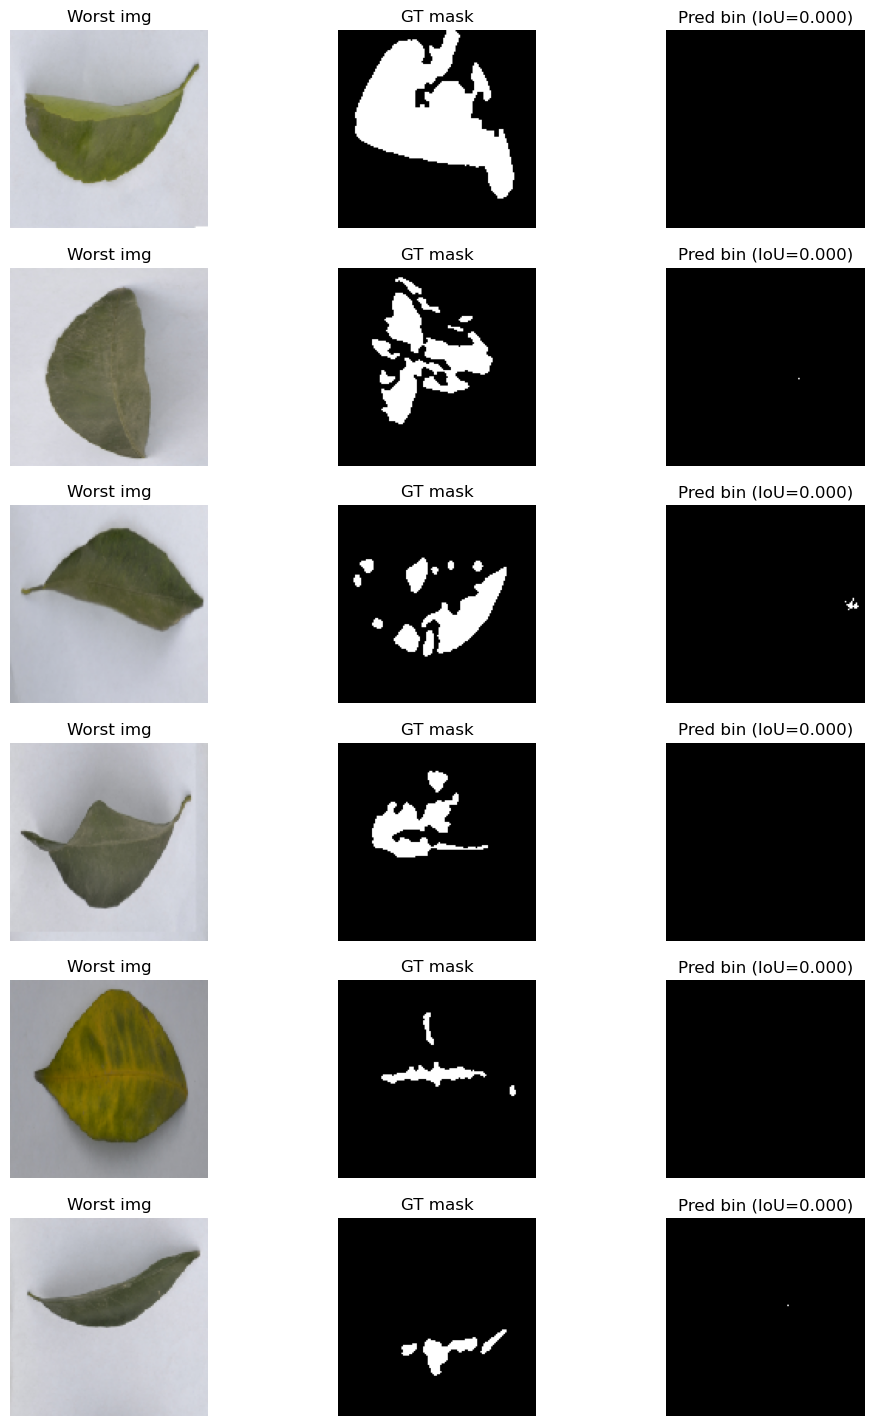

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


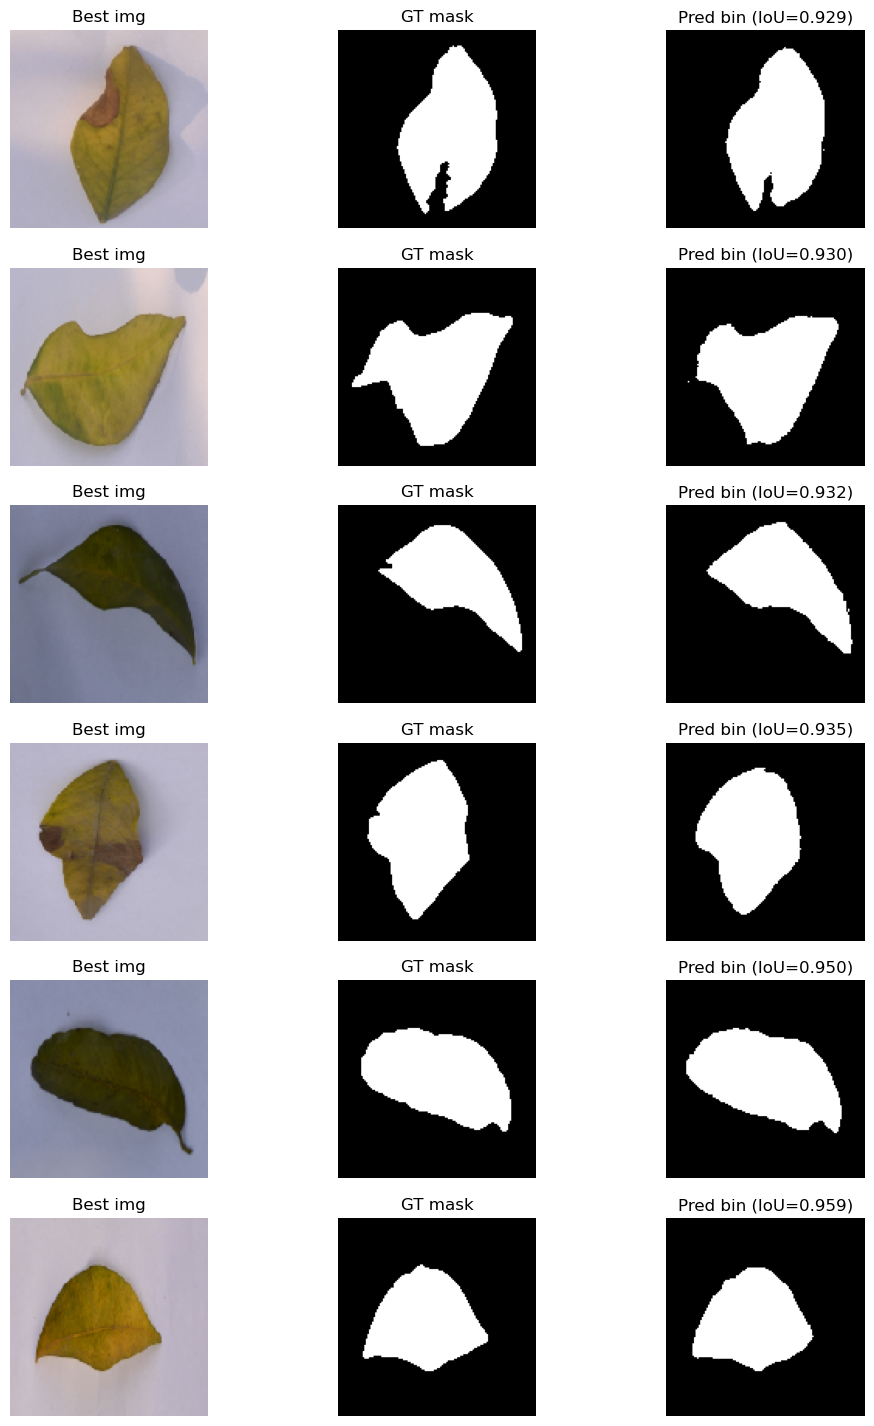

In [35]:
import numpy as np, os, matplotlib.pyplot as plt

ious = []
indices = []
gt_sums = []

# accumulate per-sample IoU and keep indexes
for i in range(len(val_seq)):
    Xb, yb = val_seq[i]
    pm, _ = model.predict(Xb)
    pm_bin = (pm > 0.5).astype(np.uint8)
    gt = yb['mask_output'].astype(np.uint8)
    for j in range(len(pm_bin)):
        if gt[j].sum() == 0:
            continue
        i_val = i * val_seq.batch_size + j
        gt_sums.append(gt[j].sum())
        cur_iou = iou_np(gt[j], pm_bin[j])
        ious.append(cur_iou)
        indices.append((i, j, cur_iou))

ious = np.array(ious)
print("Mean IoU (diseased) =", ious.mean())
print("Median IoU =", np.median(ious))
print("Std IoU =", ious.std())
print("Min IoU =", ious.min(), "Max IoU =", ious.max())

# show worst N and best N
N=6
worst = np.argsort(ious)[:N]
best  = np.argsort(ious)[-N:]

def show_examples(idxs, title):
    plt.figure(figsize=(12,3*len(idxs)))
    for k, idx in enumerate(idxs):
        i,j,_ = indices[idx]
        Xb, yb = val_seq[i]
        pm, _ = model.predict(Xb)
        img = Xb[j]
        gt = yb['mask_output'][j,:,:,0]
        pred_prob = pm[j,:,:,0]
        pred_bin = (pred_prob>0.5).astype(np.uint8)
        plt.subplot(len(idxs),3,k*3+1); plt.imshow(img); plt.title(f"{title} img"); plt.axis('off')
        plt.subplot(len(idxs),3,k*3+2); plt.imshow(gt, cmap='gray'); plt.title('GT mask'); plt.axis('off')
        plt.subplot(len(idxs),3,k*3+3); plt.imshow(pred_bin, cmap='gray'); plt.title(f'Pred bin (IoU={ious[idx]:.3f})'); plt.axis('off')
    plt.show()

show_examples(worst, "Worst")
show_examples(best, "Best")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


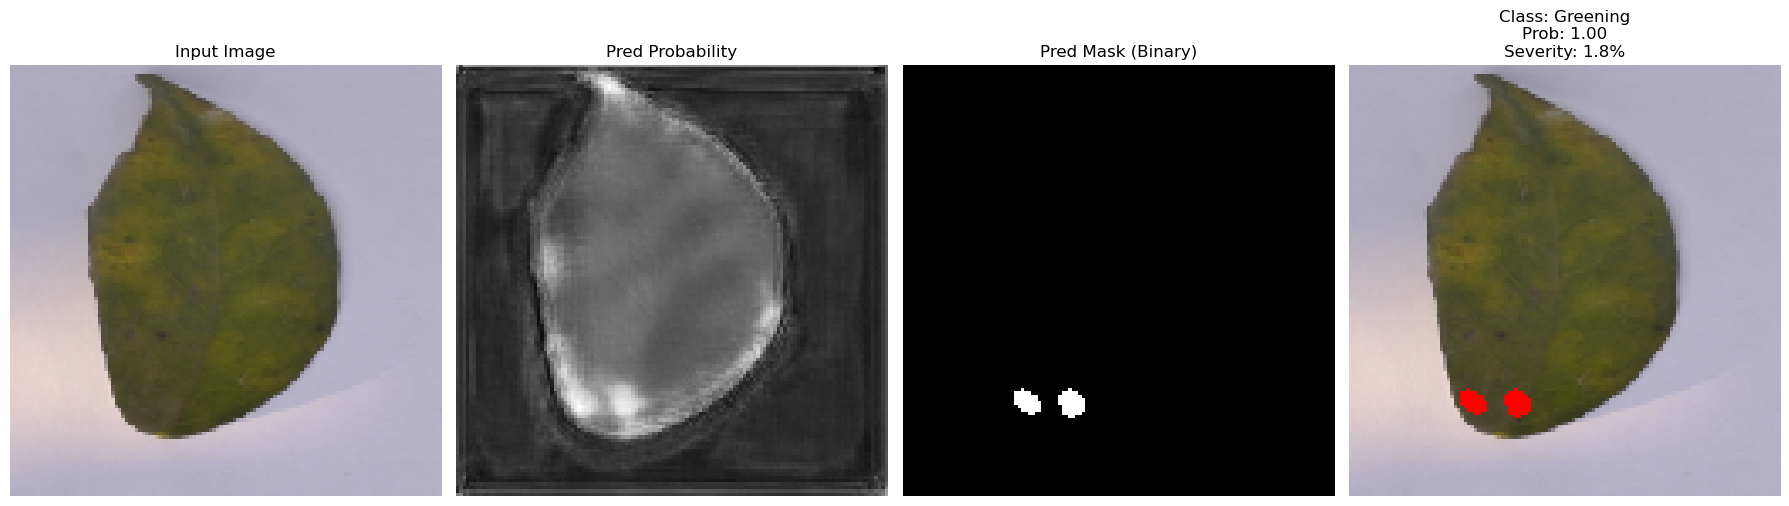

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

# ---------------- CONFIG ----------------
img_path = r"C:\Users\Maahi\Downloads\citrus_severity_project\citrus_severity_project\data\processed\train\Greening\g (199).png"   # <<< CHANGE THIS
IMG_SIZE = (128,128)
THRESH = 0.5
# ----------------------------------------

# ---- Helper functions ----
def postprocess_mask(mask_bin, kernel_size=5):
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size,kernel_size))
    mask = cv2.morphologyEx(mask_bin.astype('uint8'), cv2.MORPH_CLOSE, k)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k)
    return mask

def estimate_leaf_mask_rgb(img_rgb):
    img = (img_rgb * 255).astype('uint8')
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower = np.array([25, 30, 30])
    upper = np.array([100, 255, 255])
    leaf_mask = cv2.inRange(hsv, lower, upper)
    leaf_mask = (leaf_mask > 0).astype('uint8')
    leaf_mask = postprocess_mask(leaf_mask, 7)
    return leaf_mask if leaf_mask.sum() > 50 else None

# ---- Load and preprocess ----
pil_img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
img_arr = tf.keras.preprocessing.image.img_to_array(pil_img) / 255.0
X = np.expand_dims(img_arr, axis=0)

# ---- Predict ----
pred_mask_probs, pred_class_probs = model.predict(X)
pred_prob = pred_mask_probs[0,:,:,0]
pred_mask_bin = (pred_prob > THRESH).astype('uint8')
pred_mask_bin = postprocess_mask(pred_mask_bin)

# ---- Compute severity ----
leaf_mask = estimate_leaf_mask_rgb(img_arr)
diseased_px = pred_mask_bin.sum()

if leaf_mask is not None:
    leaf_px = leaf_mask.sum()
    severity_pct = 100 * diseased_px / leaf_px if leaf_px > 0 else 0
else:
    severity_pct = 100 * diseased_px / (IMG_SIZE[0]*IMG_SIZE[1])

# ---- Class label ----
inv_class_indices = {v:k for k,v in class_indices.items()}
pred_class_idx = pred_class_probs.argmax()
pred_class_label = inv_class_indices[pred_class_idx]
pred_class_prob = float(pred_class_probs[0][pred_class_idx])

# ---- Overlay ----
img_uint8 = (img_arr*255).astype('uint8')
overlay = img_uint8.copy()
overlay[pred_mask_bin==1] = [255,0,0]  # paint red

# ---- Display ----
fig, axs = plt.subplots(1,4, figsize=(18,5))

axs[0].imshow(img_arr)
axs[0].set_title("Input Image")
axs[0].axis('off')

axs[1].imshow(pred_prob, cmap='gray')
axs[1].set_title("Pred Probability")
axs[1].axis('off')

axs[2].imshow(pred_mask_bin, cmap='gray')
axs[2].set_title("Pred Mask (Binary)")
axs[2].axis('off')

axs[3].imshow(overlay)
axs[3].set_title(
    f"Class: {pred_class_label}\n"
    f"Prob: {pred_class_prob:.2f}\n"
    f"Severity: {severity_pct:.1f}%"
)
axs[3].axis('off')

plt.tight_layout()
plt.show()
